# Finding Lane Curvature and Vehicle Position

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
import numpy as np
import pathlib
import sys
sys.path.append("/home/car/anaconda/envs/cv/lib/python3.7/site-packages")
import cv2
import glob
import pickle

In [25]:
from lib.cv.CameraCalibration import CameraCalibration
from lib.cv.GradientThresholds import GradientThresholds
from lib.cv.ColorThresholds import ColorThresholds
%matplotlib inline

## Lane Curvature Pipeline Algorithm

1\. **Compute camera calibration matrix and distortion coefficients given a set of chessboard images** using **CameraCalibration** class's `cmpt_mtx_and_dist_coeffs()` method.

2\. **Apply distortion correction to raw images** using **CameraCalibration** class's `correct_distortion()` method. First test undistortion on a raw chessboard image and visualize it. Then test undistortion on a raw curved lane line image and visualize it.

3\. **Use color transforms, gradients, etc., to create a threshold binary image**.

## 1. Compute Camera Calibration Matrix and Distortion Coefficients 
---

In [3]:
nx_corners = 9
ny_corners = 6
# Choose a directory with camera images of 9x6 chessboards
cam_cal_chess_dfp = "camera_cal/calibration*.jpg"
smart_car_cam = CameraCalibration(nx_corners, ny_corners, cam_cal_chess_dfp)

# Compute camera calibration matrix and distortion coefficients via a set of chessboard images
src_img_fp = "camera_cal/calibration3.jpg"
cal_mtx, dist_coeff = smart_car_cam.cmpt_mtx_and_dist_coeffs(src_img_fp)

## 2. Apply Distortion Correction to Raw Images
---

### 2A. Correct Distortion on a Raw Chessboard Image

In [4]:
# Apply Distortion Correction to a raw chessboard image
chess_dist_img, chess_undist_img = smart_car_cam.correct_distortion(src_img_fp, cal_mtx, dist_coeff)

# Save Undistorted Chessboard Image
dst_img_fp = "camera_cal/chess_undist3" # image extension will be added in below function
smart_car_cam.save_undistorted_img(dst_img_fp, chess_undist_img, cal_mtx, dist_coeff)

### Visualize Distortion Correction of Chessboard Image

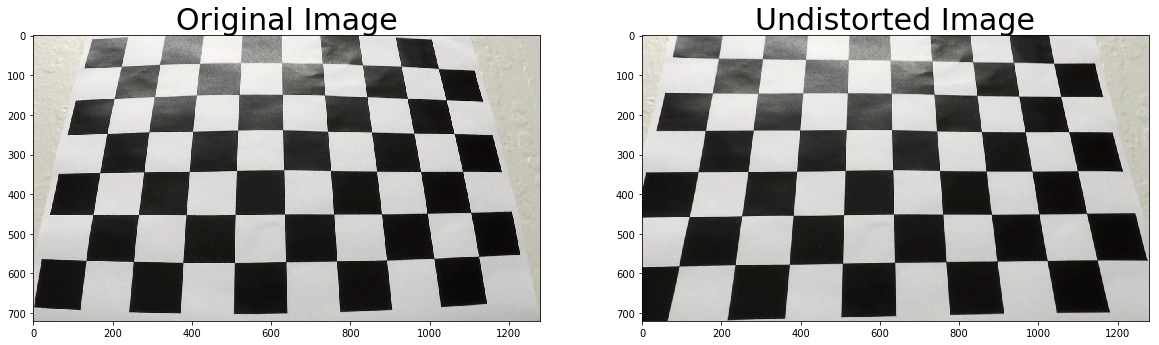

In [5]:
# Visualize Chessboard Image from Distorted and Undistorted 
smart_car_cam.visualize_undistortion(chess_dist_img, chess_undist_img)

### 2B. Correct Distortion on a Raw Curved Lane Line Image

In [6]:
# Apply Distortion Correction to a raw curved lane line image
src_img_fp = "test_images/test1.jpg"
curved_dist_img, curved_undist_img = smart_car_cam.correct_distortion(src_img_fp, cal_mtx, dist_coeff)

# Save Undistorted Curved Lane Line Image
dst_img_fp = "test_images/curved_lane_undist1" # image extension will be added in below function
smart_car_cam.save_undistorted_img(dst_img_fp, curved_undist_img, cal_mtx, dist_coeff)

### Visualize Distortion Correction of Curved Lane Line Image

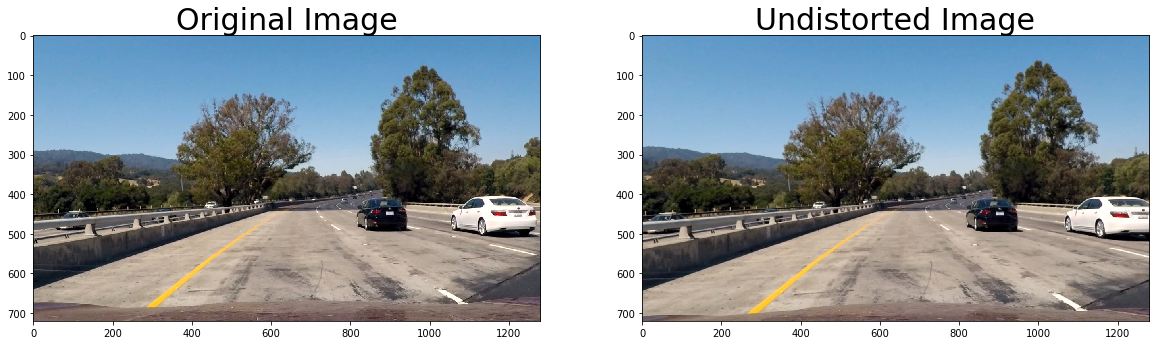

In [7]:
# Visualize Chessboard Image from Distorted and Undistorted 
smart_car_cam.visualize_undistortion(curved_dist_img, curved_undist_img)

## 3. Create a Thresholded Binary Image
---

### 3A. Use Gradient Thresholds to Create Binary Image

### Apply X-Sobel Orientation Derivative Thresholding

Identifies pixels where the gradient of an image falls within a specified threshold range. 
Can also take the Y-Sobel, but found X-Sobel to be better at picking up lane lines.

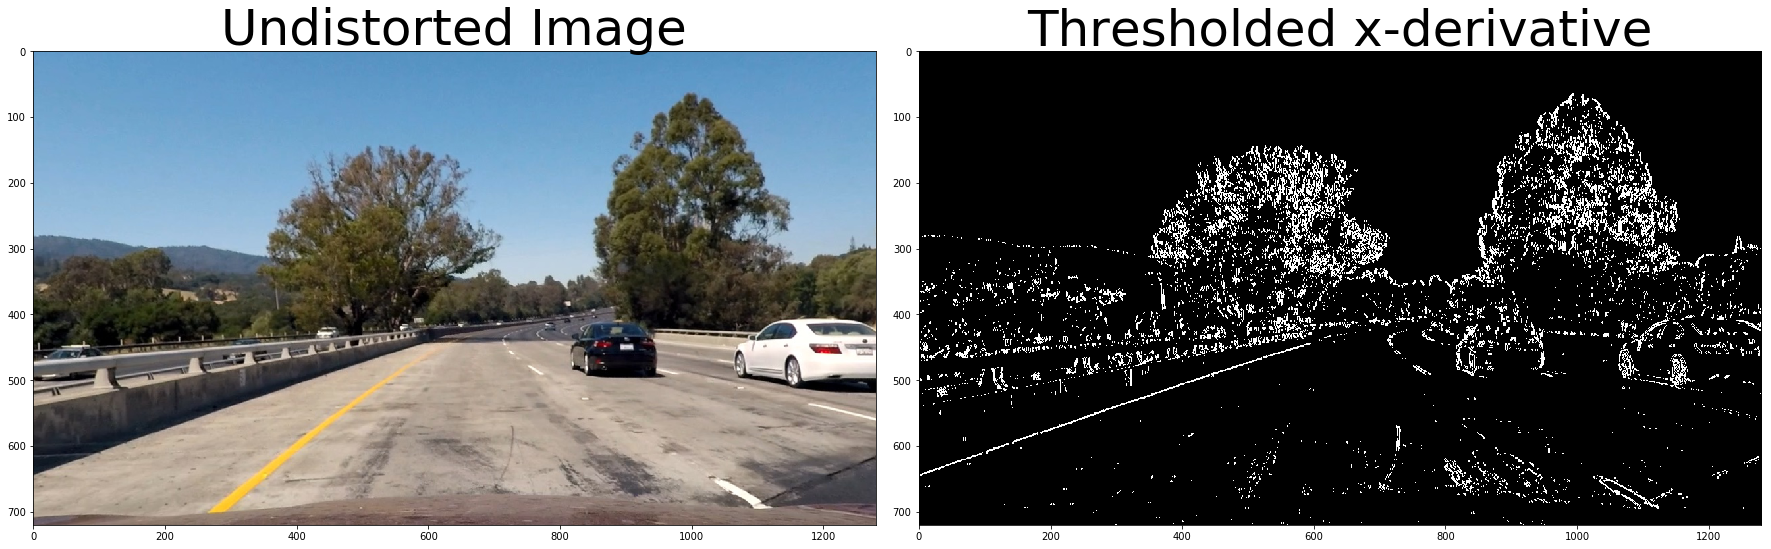

In [8]:
# Applies Gradient Thresholding to Undistorted Car Camera Images
orient = 'x'
thresh_min = 20
thresh_max = 100
gradient_car_cam = GradientThresholds(curved_undist_img)
grad_binary_img = gradient_car_cam.apply_sobel_thresh(curved_undist_img, orient, thresh_min, thresh_max)
# Visualizes a figure with undistorted image and gradient thresholded image
thresh_img_title = 'Thresholded x-derivative'
gradient_car_cam.visualize_thresholded_img(curved_undist_img, grad_binary_img, thresh_img_title)

### Apply Both X and Y Gradient Magnitude Thresholding

This thresholding can be done over larger regions to smooth over noisy intensity 
fluctuations on small scales

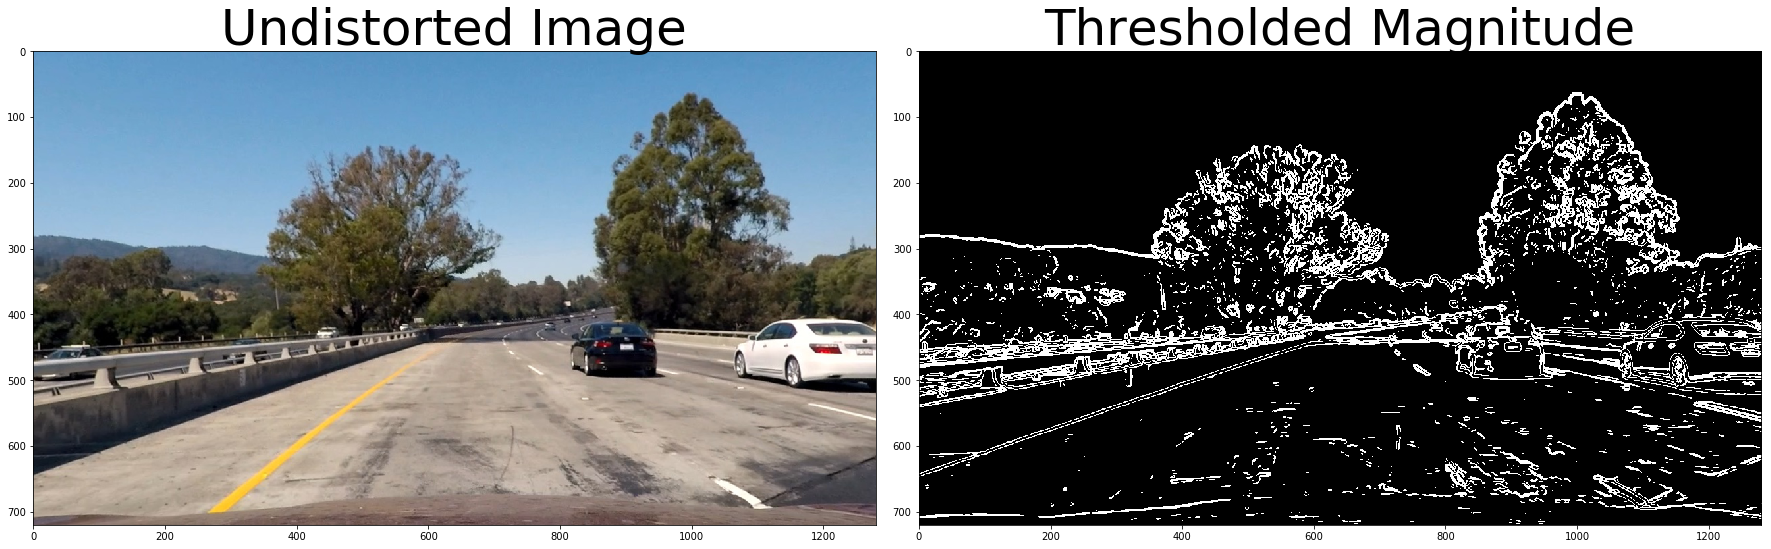

In [9]:
sobel_kernel = 9
mag_thresh = (30, 100)
grad_mag_binary_img = gradient_car_cam.apply_grad_mag_thresh(curved_undist_img, sobel_kernel, mag_thresh)
# Visualizes a figure with undistorted image and gradient magnitude thresholded image
thresh_img_title = 'Thresholded Magnitude'
gradient_car_cam.visualize_thresholded_img(curved_undist_img, grad_mag_binary_img, thresh_img_title)

### Apply Gradient Direction Thresholding

This thresholding is useful for picking up edges of a particular orientation.

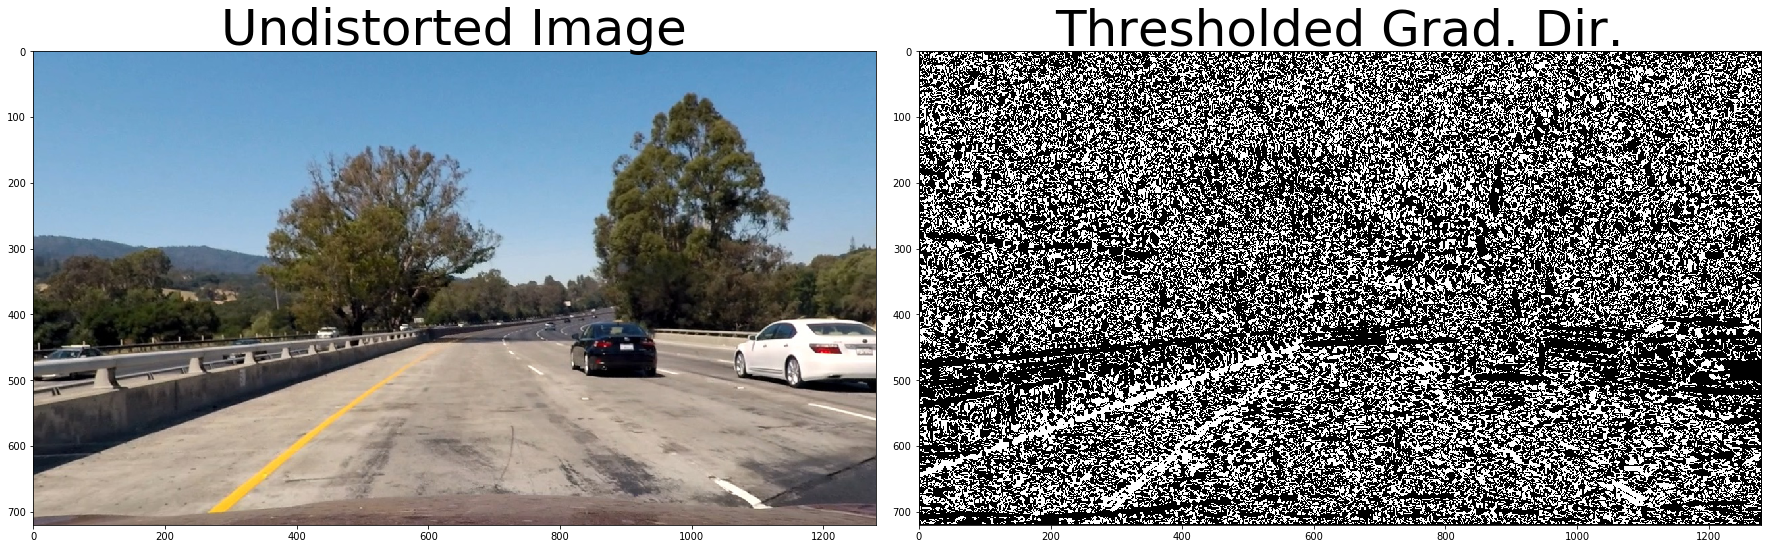

In [10]:
sobel_kernel = 15
dir_thresh = (0.7, 1.3)
dir_binary_img = gradient_car_cam.apply_grad_dir_thresh(curved_undist_img, sobel_kernel, dir_thresh)
# Visualizes a figure with undistorted image and gradient direction thresholded image
thresh_img_title = 'Thresholded Grad. Dir.'
gradient_car_cam.visualize_thresholded_img(curved_undist_img, dir_binary_img, thresh_img_title)

### Apply Combined Gradient Thresholds

Use various aspects of gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels. First, I did a selection for pixels where x and y gradients meet the threshold criteria or the gradient magnitude and direction are both within their threshold values.

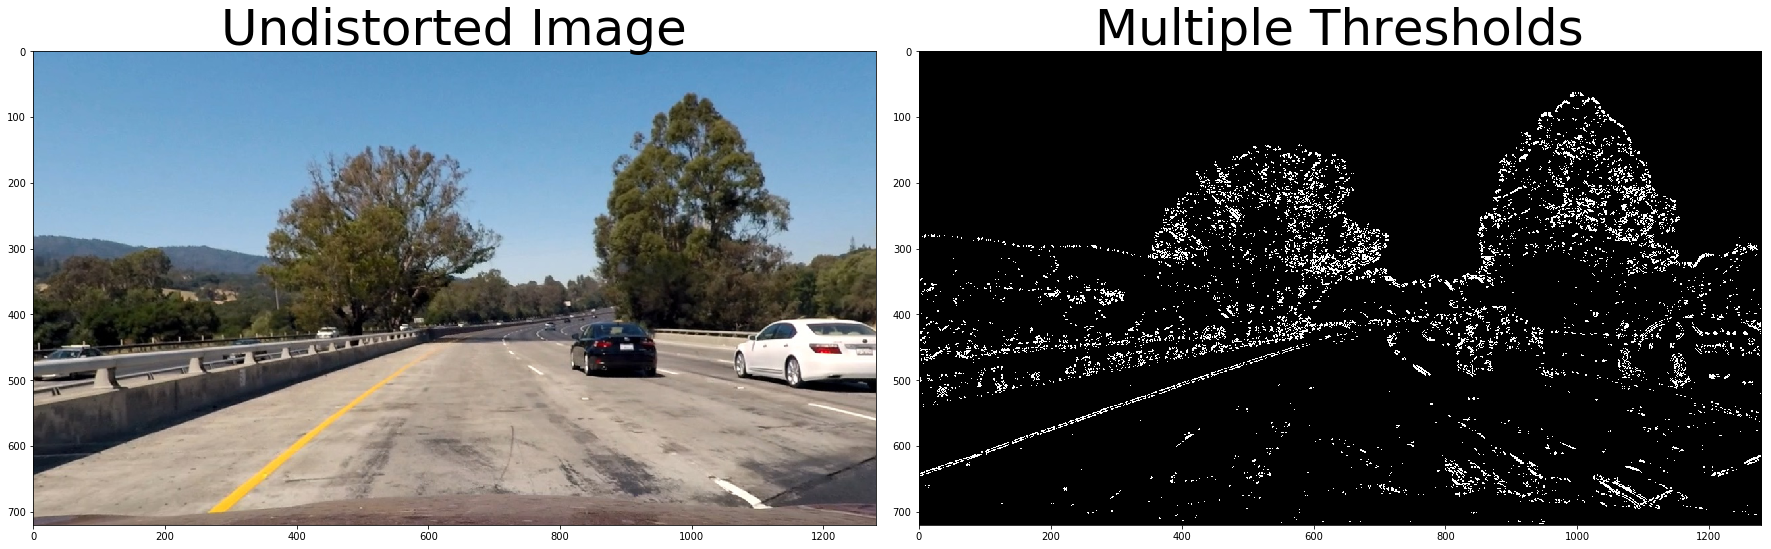

In [11]:
sobel_kernel = 7
thresh = (0, 255)
combined_binary_img = gradient_car_cam.apply_combined_thresh(curved_undist_img, sobel_kernel)
thresh_img_title = 'Multiple Thresholds'
gradient_car_cam.visualize_thresholded_img(curved_undist_img, combined_binary_img, thresh_img_title)

### 3B. Use Color Thresholds to Create Binary Image

In [12]:
color_car_cam = ColorThresholds()

### Apply Grayscale Thresholding

Convert to grayscale and apply a threshold to identify lane lines

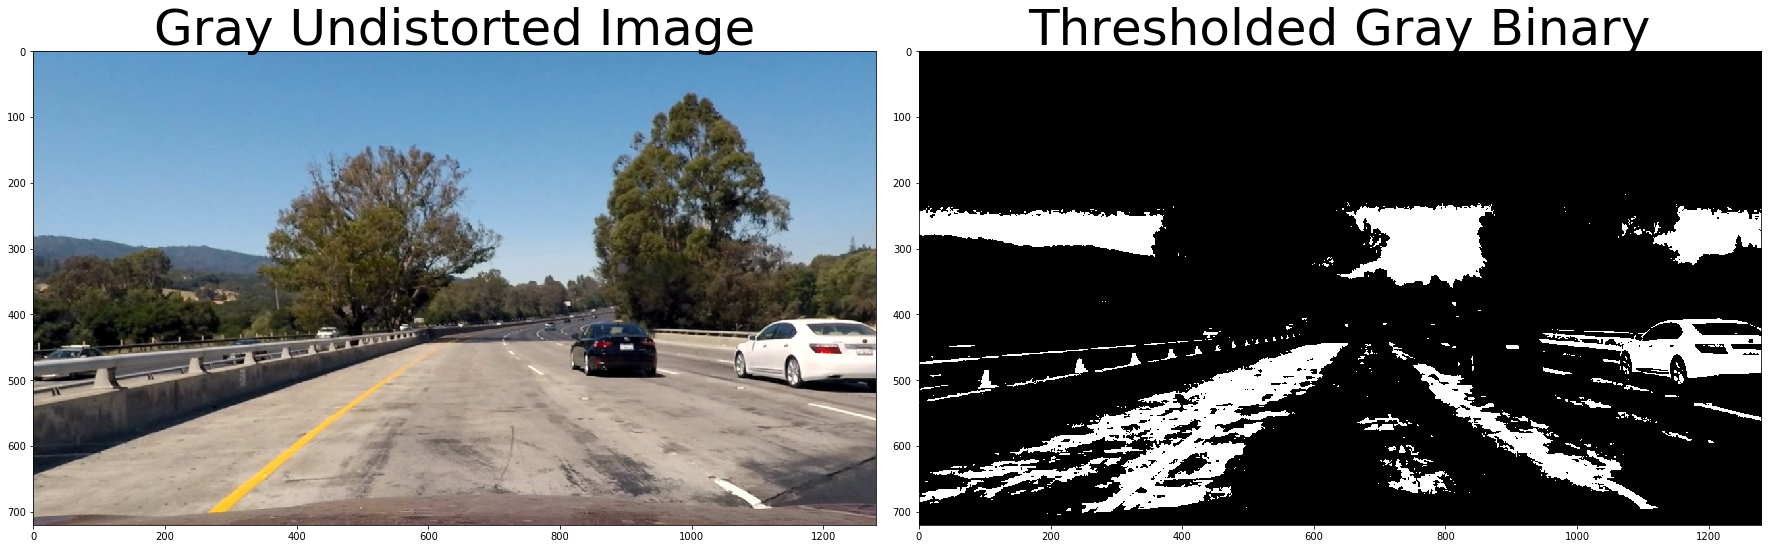

In [13]:
thresh = (180, 255)
gray_binary_img = color_car_cam.apply_gray_thresh(curved_undist_img, thresh)
undist_img_title = 'Gray Undistorted Image'
thresh_img_title = 'Thresholded Gray Binary'
color_car_cam.visualize_thresholded_img(curved_undist_img, gray_binary_img, undist_img_title, thresh_img_title)

### Apply Invidual RGB Thresholding

Use Red, Green, Blue Color Space to highlight lane lines and apply a threshold to find lane-line pixels of a particular color

#### Apply R Thresholding

Use R channel to highlight lines and apply threshold to find lane-lines

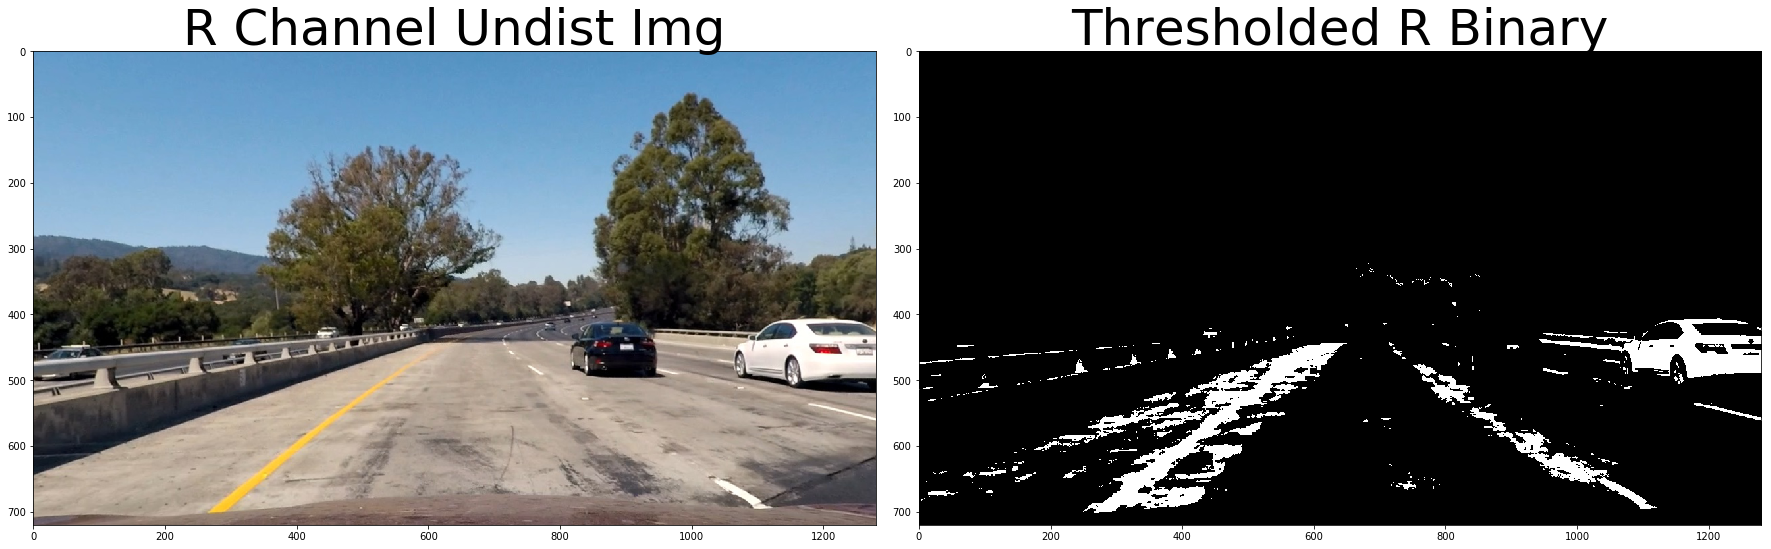

In [20]:
r_thresh = (200, 255)
red_binary_img = color_car_cam.apply_r_thresh(curved_undist_img, r_thresh)
undist_img_title = 'R Channel Undist Img'
thresh_img_title = 'Thresholded R Binary'
color_car_cam.visualize_thresholded_img(curved_undist_img, red_binary_img, undist_img_title, thresh_img_title)

#### Apply G Thresholding

Use G channel to highlight lines and apply threshold to find lane-lines

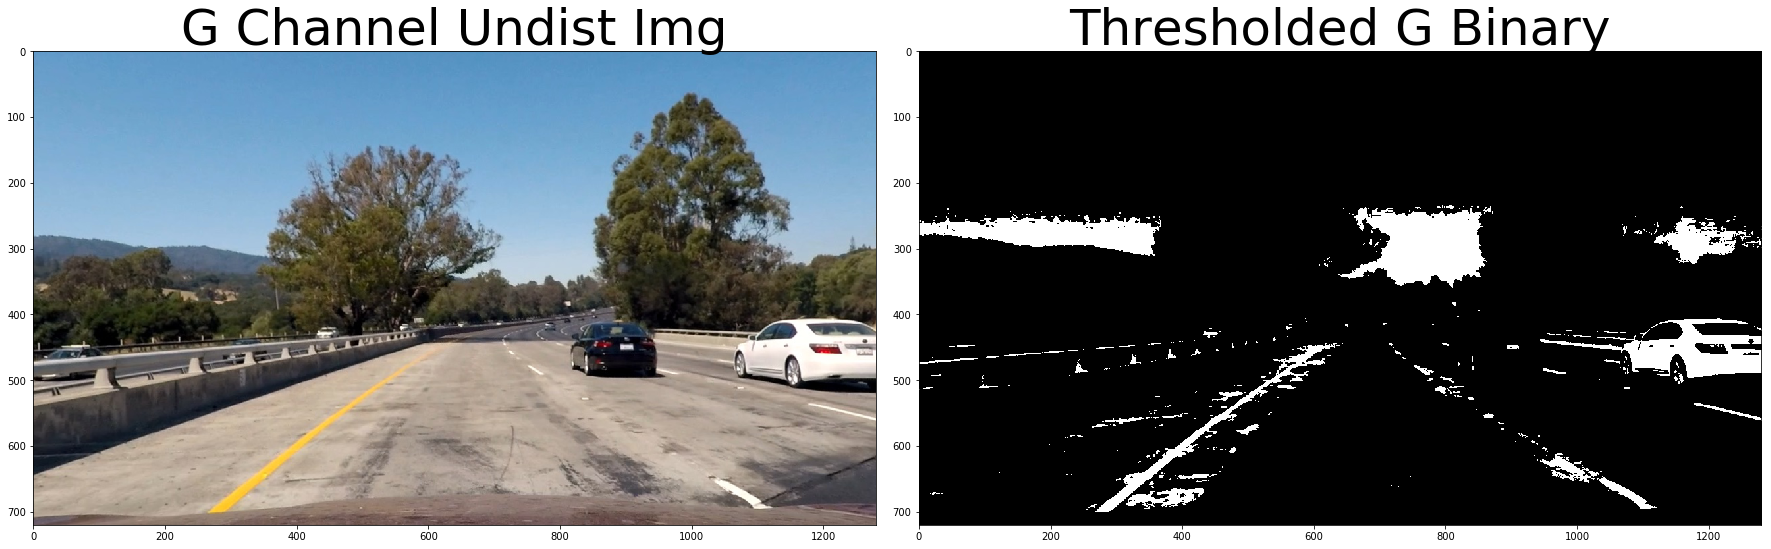

In [21]:
g_thresh = (190, 255)
green_binary_img = color_car_cam.apply_g_thresh(curved_undist_img, g_thresh)
undist_img_title = 'G Channel Undist Img'
thresh_img_title = 'Thresholded G Binary'
color_car_cam.visualize_thresholded_img(curved_undist_img, green_binary_img, undist_img_title, thresh_img_title)

#### Apply B Thresholding

Use B channel to highlight lines and apply threshold to find lane-lines

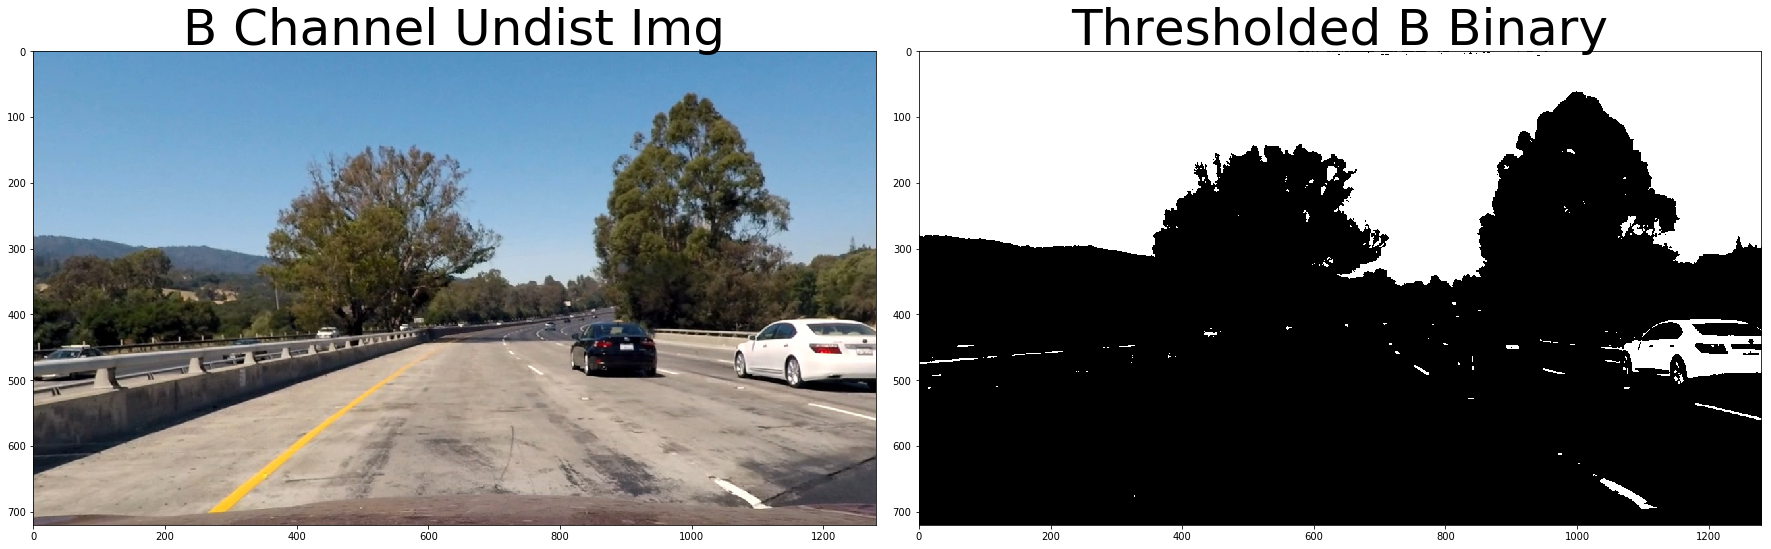

In [22]:
b_thresh = (190, 255)
blue_binary_img = color_car_cam.apply_b_thresh(curved_undist_img, b_thresh)
undist_img_title = 'B Channel Undist Img'
thresh_img_title = 'Thresholded B Binary'
color_car_cam.visualize_thresholded_img(curved_undist_img, blue_binary_img, undist_img_title, thresh_img_title)

### Apply RGB Thresholding

In [26]:
rgb_thresh = [ r_thresh, g_thresh, b_thresh ]
rgb_binary_img = color_car_cam.apply_rgb_thresh(curved_undist_img, rgb_thresh)
undist_img_title = 'RGB Channel Undist Img'
thresh_img_title = 'Thresholded RGB Binary'
color_car_cam.visualize_thresholded_img(curved_undist_img, rgb_binary_img, undist_img_title, thresh_img_title)

ValueError: operands could not be broadcast together with shapes (720,1280) (2,) 

## Calculating Lane Curvature

In [ ]:
# Driving on a highway, you take a look at the road in front of you 
# and the cars around you. You press the gas or break to go with the flow and
# based on how much the lane is curving left or right, you curve the steering
# wheel to stay in that lane.

# How does this work for a self-driving car?
# Self-Driving cars need to be told the correct steer angle to turn left or 
# right. We can calculate this angle if we know the speed and dynamics
# of the car and how much the lane is curving.

# To Determine the Lane Curvature:
# 1. Detect the Lane Lines using Masking and Thresholding techniques
# 2. Perform a Perspective Transform to get a bird's eye view of the lane
# (which let's us fit a polynomial to the lane lines)
# 3. Extract Lane Curvature from this polynomial using Math

# Lane Curvature Line Fittign Equation:
# f(y) = Ay^2 + By + C
# A gives curvature of lane line
# B gives heading or direction line is pointing
# C gives position of line based on how far away it is from left of an image (y = 0)

